## Accessing ASTER data on Azure

The [ASTER](https://terra.nasa.gov/about/terra-instruments/aster) instrument, launched on-board NASA's [Terra](https://terra.nasa.gov/) satellite in 1999, provides multispectral images of the Earth at 15m-90m resolution.  This data set represents ASTER data from 2000-2006.

This notebook demonstrates basic access to ASTER data on Azure, using the NASA CMR API to query for tiles, then accessing the tiles on Azure blob storage.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in West Europe.  We recommend that substantial computation depending on this data also be situated in West Europe.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-aster](http://aka.ms/ai4edata-aster).

### Imports

In [9]:
# Standard or standard-ish imports
import datetime
import urllib
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Less standard, but still pip- or conda-installable
from rasterio.windows import Window
from pyproj import Transformer        
from azure.storage.blob import ContainerClient
from cmr import GranuleQuery

### Constants

In [10]:
# Let's take a look at an area in Japan that looks interesting in the ASTER VNIR bands
query_lat = 35.08409151423969
query_lon = 138.55814925655318
query_short_name = 'AST_L1T'

query_start_date = datetime.datetime(2002, 1, 1, 0, 0, 0)
query_end_date = datetime.datetime(2004, 12, 1, 0, 0, 0)

# Which image type (SWIR, TIR, VNIR) should we render?
image_type = 'VNIR'

# Which bands from the image should we use for composite rendering?
composite_bands = [3,2,1]

# We're going to render a nice image at the end, set the size and "zoom"
target_size = [1920,1114]
zoom = 1.0

### Azure storage constants

In [11]:
storage_account_name = 'astersa'
container_name = 'aster'
storage_account_url = \
  'https://' + storage_account_name + '.blob.core.windows.net/'

container_client = ContainerClient(account_url=storage_account_url, 
                                             container_name=container_name, credential=None)

### Search for granules

In [12]:
api = GranuleQuery()
granules = api.short_name(query_short_name).point(query_lon,query_lat).temporal(query_start_date, query_end_date).get()

print('Found {} matching granules'.format(len(granules)))

Found 54 matching granules


### Grab the granule with the lowest cloud cover

In [13]:
# Sort by cloud cover
for granule in granules:
    granule['cloud_cover'] = float(granule['cloud_cover'])
granules = sorted(granules, key=lambda k: k['cloud_cover'])
granule = granules[0]
print(granule['producer_granule_id'])

AST_L1T_00310042002014048_20150425134514_6769


### Prepare the scene prefix

In [14]:
# For the product:
#
# AST_L1T_00301152004192004_20150502205642_77732
#    
# Our path is:
#    
# https://astersa.blob.core.windows.net/aster/images/L1T/2004/01/15/AST_L1T_00301152004192004_20150502205642_77732.hdf
#
# images/L1T/2004/01/15/AST_L1T_00301152004192004_20150502205642_77732.hdf

granule_id = granule['producer_granule_id']
assert granule_id[0:11] == 'AST_L1T_003'

# E.g. 01152004
granule_date_string = granule_id[11:19]

granule_month = granule_date_string[0:2]
granule_day = granule_date_string[2:4]
granule_year = granule_date_string[4:8]

azure_scene_prefix = '/'.join(['images','L1T',granule_year,granule_month,granule_day,granule_id])

# List all files matching this prefix
generator = container_client.list_blobs(name_starts_with=azure_scene_prefix)
image_paths = [blob.name for blob in generator if blob.name.endswith('.tif')]
print('Found {} matching images:'.format(len(image_paths)))
for s in image_paths:
    print(s)

Found 3 matching images:
images/L1T/2002/10/04/AST_L1T_00310042002014048_20150425134514_6769.SWIR.tif
images/L1T/2002/10/04/AST_L1T_00310042002014048_20150425134514_6769.TIR.tif
images/L1T/2002/10/04/AST_L1T_00310042002014048_20150425134514_6769.VNIR.tif


### Convert to URLs

In [15]:
image_urls = [storage_account_url + container_name + '/' + p for p in image_paths]
for s in image_urls:
    print(s)

https://astersa.blob.core.windows.net/aster/images/L1T/2002/10/04/AST_L1T_00310042002014048_20150425134514_6769.SWIR.tif
https://astersa.blob.core.windows.net/aster/images/L1T/2002/10/04/AST_L1T_00310042002014048_20150425134514_6769.TIR.tif
https://astersa.blob.core.windows.net/aster/images/L1T/2002/10/04/AST_L1T_00310042002014048_20150425134514_6769.VNIR.tif


### Render COG previews without reading the whole file

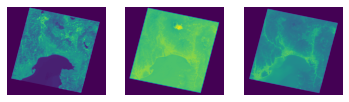

In [16]:
thumbnail_data = []

# url = azure_cog_urls[0]
for url in image_urls:
    
    # From:
    #
    # https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
    with rasterio.open(url) as raster:
        
        # List of overviews from biggest to smallest
        oviews = raster.overviews(1)
    
        # Retrieve the smallest thumbnail
        decimation_level = oviews[-1]
        h = int(raster.height/decimation_level)
        w = int(raster.width/decimation_level)
        
        thumbnail_channel = raster.read(1, out_shape=(1, h, w))
        thumbnail_data.append(thumbnail_channel)

fig, axes = plt.subplots(1, 3, frameon=False)

for i,d in enumerate(thumbnail_data):
    axes[i].imshow(d)
    axes[i].set_axis_off()

### Make an RGB composite of the whole tile

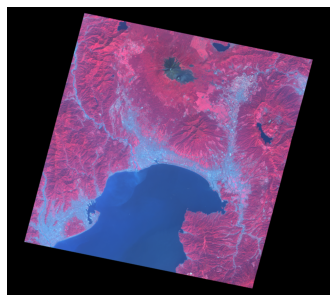

In [17]:
# Downscaling factor used when rendering whole-tile composite
dsfactor = 3

# Normalization value per channel
norm_value_composite = [100,100,100]

image_data = []

with rasterio.open(url,'r') as src:
    
    h = int(src.height//dsfactor)
    w = int(src.width//dsfactor)
    
    for i,band in enumerate(composite_bands):
        band_array = src.read(band, out_shape=(1, h, w))
        band_array = band_array / norm_value_composite[i]
        image_data.append(band_array)
    src.close()
        
rgb = np.dstack((image_data[0],image_data[1],image_data[2]))
np.clip(rgb,0,1,rgb)
fig = plt.figure(frameon=False)
ax = plt.Axes(fig,[0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(rgb)  

### Crop a region from the image

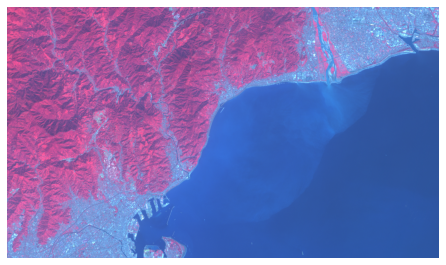

In [18]:
# This will be an array of rasters (R,G,B)
image_data = []

with rasterio.open(url,'r') as src:
    
    # Choose the target image size
    xsize = (target_size[0] * zoom)
    ysize = (target_size[1] * zoom)
    
    # Find the transformation from pixels to lat/lon
    transformer = Transformer.from_crs('EPSG:4326', src.crs, always_xy=True)
    xx, yy = transformer.transform(query_lon,query_lat)
    py, px = src.index(xx,yy)    
    xoff = px - xsize // 2 
    yoff = py - ysize // 2 
    window = Window(xoff,yoff,xsize,ysize)
    
    for i,band in enumerate(composite_bands):
        band_array = src.read(band, window=window)
        band_array = band_array / norm_value_composite[i]
        image_data.append(band_array)
    
    src.close()
    image_data.append(band_array)

# ...with rasterio.open()

rgb = np.dstack((image_data[0],image_data[1],image_data[2]))
np.clip(rgb,0,1,rgb)

fig = plt.figure(frameon=False)
ax = plt.Axes(fig,[0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(rgb)